In [1]:
import sys
from pathlib import Path

IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules
if IS_KAGGLE:
    repo_path = Path("../input/microstructure-reconstruction")
elif IS_COLAB:
    from google.colab import drive

    drive.mount("/content/gdrive")
    repo_path = Path("/content/gdrive/MyDrive/microstructure-reconstruction")
else:
    repo_path = Path("/home/matias/microstructure-reconstruction")
sys.path.append(str(repo_path))

import re
from copy import deepcopy
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import torchvision.models as pretrained_models
import wandb
from custom_datasets import dataset
from custom_models import models
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler
from tools import dataframe_reformat, inspect_code, plotting, training, wandb_api
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from tqdm import tqdm

wandb_api.login()
api = wandb.Api()
run_name = "1oaqiv4c"
run = api.run(f"matiasetcheverry/microstructure-reconstruction/{run_name}")
config = run.config

use_cuda = torch.cuda.is_available()
config["device"] = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 2, "pin_memory": True} if use_cuda else {"num_workers": 4}
print(f"[INFO]: Computation device: {config['device']}")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matiasetcheverry (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/matias/.netrc


[INFO]: Computation device: cpu


In [36]:
mean_run_name = "va83a469"
mean_run = api.run(f"matiasetcheverry/microstructure-reconstruction/{mean_run_name}")
mean_metric = mean_run.history()


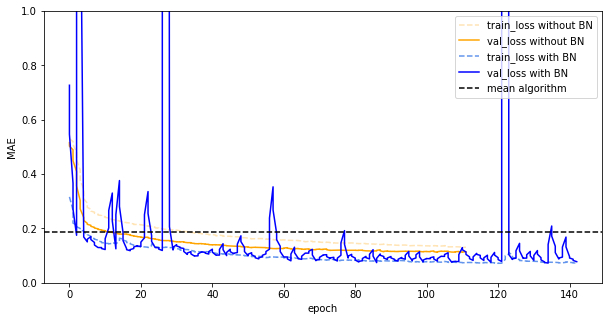

In [104]:
run_names = ["2j935yxp", "xifcht90"]
runs = [
    api.run(f"matiasetcheverry/microstructure-reconstruction/{run_name}")
    for run_name in run_names
]
metrics = [run.history() for run in runs]
n = 10
fig, ax = plt.subplots(figsize=(10, 5))
metrics[0].interpolate(method="linear").plot(
    x="epoch",
    y=["train_loss", "val_loss"],
    ax=ax,
    color=["moccasin", "orange"],
    style=["--", "-"],
)
metrics[1].interpolate(method="linear").plot(
    x="epoch",
    y=["train_loss", "val_loss"],
    ax=ax,
    color=["cornflowerblue", "blue"],
    style=["--", "-"],
    ylabel="MAE",
)
ax.axhline(y=mean_metric["val_loss"].iloc[0], color="black", linestyle="--")
ax.set_ylim([0, 1])
ax.legend(
    [
        "train_loss without BN",
        "val_loss without BN",
        "train_loss with BN",
        "val_loss with BN",
        "mean algorithm",
    ],
    bbox_to_anchor=(1, 1),
    loc=1,
)


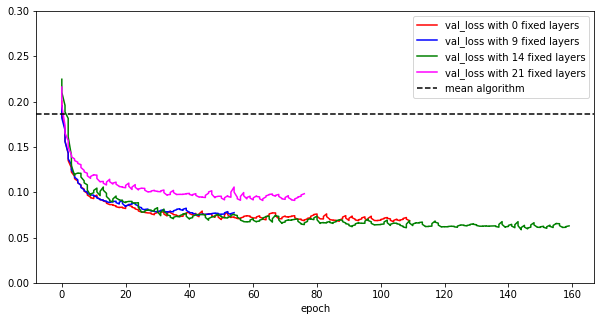

In [112]:
run_names = ["xs4ssxd8", "1y9ad1tk", "1oaqiv4c", "3j22gxki"]
runs = [
    api.run(f"matiasetcheverry/microstructure-reconstruction/{run_name}")
    for run_name in run_names
]
metrics = [run.history() for run in runs]
n = 5
fig, ax = plt.subplots(figsize=(2 * n, n))
colors = ["red", "blue", "green", "magenta"]
for metric, color in zip(metrics, colors):
    metric.interpolate(method="linear").plot(
        x="epoch",
        y=["val_loss"],
        ax=ax,
        color=color,
        style=["-"],
    )
ax.set_ylim([0, 0.3])
ax.axhline(y=mean_metric["val_loss"].iloc[0], color="black", linestyle="--")
ax.legend(
    [
        "val_loss with 0 fixed layers",
        "val_loss with 9 fixed layers",
        "val_loss with 14 fixed layers",
        "val_loss with 21 fixed layers",
        "mean algorithm",
    ],
    bbox_to_anchor=(1, 1),
    loc=1,
)


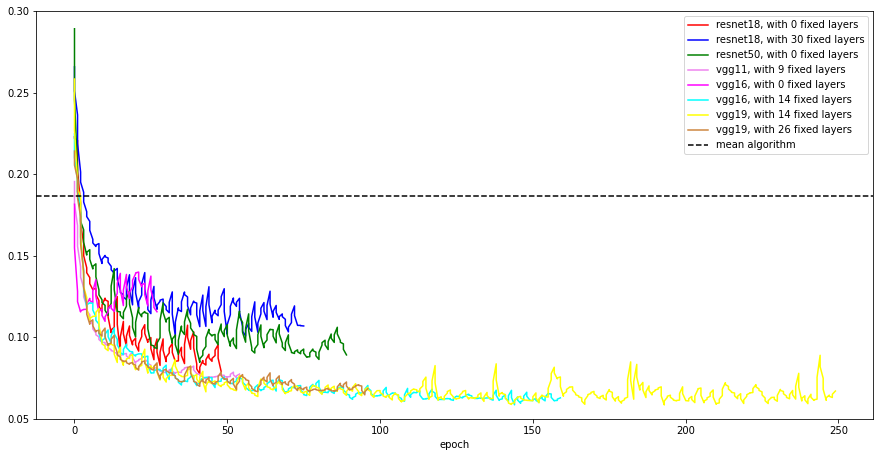

In [114]:
run_names = [
    "26avtedt",
    "1dbeoh5g",
    "2f8wwu5m",
    "1y9ad1tk",
    "g8r0nom6",
    "1oaqiv4c",
    "2vagmry1",
    "n5h17w1w",
]
runs = [
    api.run(f"matiasetcheverry/microstructure-reconstruction/{run_name}")
    for run_name in run_names
]

model_names = []
configs = []
root_path = Path("tmp")
for run in runs:
    model_script = run.file("model_script.txt")
    model_script = model_script.download(root=root_path / run.name, replace=True)
    model_script.seek(0)

    possible_model_names = re.findall(
        r"(?<=pretrained_models.)(.*?)(?=\_bn)|(?<=pretrained_models.)(.*?)(?=\()",
        model_script.read(),
    )[0]
    model_name = [
        possible_model_name
        for possible_model_name in possible_model_names
        if len(possible_model_name) > 0
    ]
    model_names.append(model_name[0])
    configs.append(run.config)

legends = [
    f"{model_name}, with {config['fixed_layers']} fixed layers"
    for model_name, config in zip(model_names, configs)
] + ["mean algorithm"]

metrics = [run.history() for run in runs]

n = 7.5
fig, ax = plt.subplots(figsize=(2 * n, n))
colors = ["red", "blue", "green", "violet", "magenta", "cyan", "yellow", "peru"]
for metric, color in zip(metrics, colors):
    metric.interpolate(method="linear").plot(
        x="epoch",
        y=["val_loss"],
        ax=ax,
        color=color,
        style=["-"],
    )
ax.axhline(y=mean_metric["val_loss"].iloc[0], color="black", linestyle="--")
ax.set_ylim([0.05, 0.3])
ax.legend(
    legends,
    bbox_to_anchor=(1, 1),
    loc=1,
)
